# Result Analysis
This notebook analyzes the experimental results and reproduces the figures presented in the paper:
**"Probabilistic Response-Time-Aware Search for Transient Astrophysical Phenomena."**
Specifically, it generates plots for the following scenarios evaluated in the study:

1. **Small Instances with a Single Deadline**  
   Evaluation of various search strategies on small-scale sky maps, assuming a single observation deadline.

2. **Large Instances with a Single Deadline**  
   Evaluation on larger-scale sky maps, again under a single deadline constraint.

3. **Small Instances with Response-Time-Aware Budgeting (MOET-Aware)**  
   Incorporates maximum-observed execution time (MOET) per method to adjust the effective observation budget for small instances.

4. **Large Instances with Multiple Deadlines**  
   Considers time-sensitive search scenarios where different segments of the observation budget become available at multiple deadlines.

Each section of the notebook corresponds to one of these experimental settings, reproducing the corresponding figures from the paper and enabling further exploration of the results.

## Section 0: Imports and Plot Settings
This section loads all required libraries and defines plot styling to match the paper's visual standards (e.g., font size, axis labels, error bars).

### Set a root path

- (DEFAULT): If you want to generate the plots using precomputed results please set the root path to **precomputed_results**
- If you want to generate the plots using recomputed results that you run from scrach, please set the root path to **recomputed_results** 

In [1]:
root_path = "precomputed_results"
# root_path = "recomputed_results"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import sem
import warnings
import matplotlib as mpl

warnings.filterwarnings("ignore")

mpl.rcParams.update({
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 13
})


In [3]:
method_markers = {
    'GCP': 'o',
    'Greedy': 'D',
    'ACO': '^',
    'ILP': 'v',
    'Genetic': 'X',
}

**Helper Functions**
These functions handle loading, aggregating, and formatting result CSVs for visualization.

In [4]:
def get_csv_files(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

def read_and_aggregate(folder_path):
    all_dfs = []
    for filepath in get_csv_files(folder_path):
        try:
            df = pd.read_csv(filepath)
            df["DatasetName"] = os.path.basename(df["Dataset"].iloc[0])
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
    return pd.concat(all_dfs, ignore_index=True)

## Section 1: Figure 7, Small Instances with a Single Deadline

- Compares search strategies on small-scale sky maps.

- Evaluates relative FoM performance (% deviation) against the ILP (Gurobi) baseline.

In [5]:
method_display_names = {
    'Hoogeveen': 'GCP',
    'Greedy': 'Greedy',
    'Gurobi': 'ILP',
    'Genetic': 'Genetic',
}
selected_methods = list(method_display_names.keys())

folder_path = f"{root_path}/small"
df_all = read_and_aggregate(folder_path)
df_filtered = df_all[df_all['Method'].isin(selected_methods)].copy()
df_filtered["DisplayMethod"] = df_filtered["Method"].map(method_display_names)

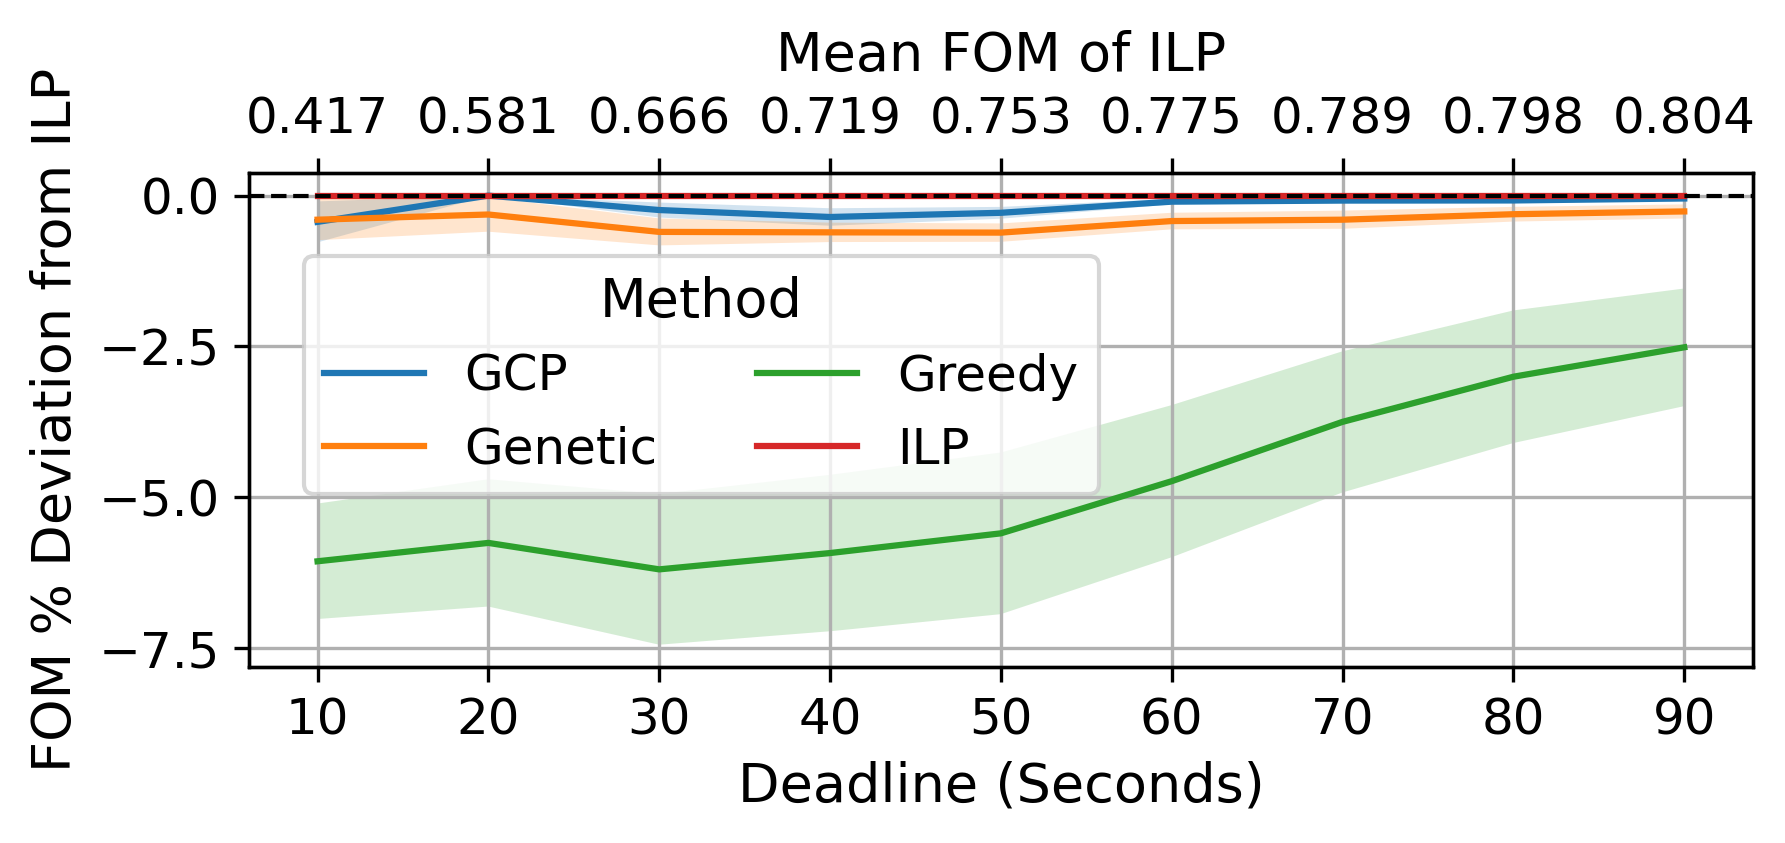

In [6]:
agg = df_filtered.groupby(['DisplayMethod', 'Budget'])['SumProb'].agg(['mean', sem]).reset_index()
baseline = df_filtered[df_filtered['DisplayMethod'] == 'ILP'][['DatasetName', 'Budget', 'SumProb']]
baseline = baseline.rename(columns={'SumProb': 'BaselineFOM'})

df_dev = pd.merge(df_filtered, baseline, on=['DatasetName', 'Budget'])
df_dev['FOMDeviation'] = df_dev['SumProb'] - df_dev['BaselineFOM']

df_dev['FOMPctDeviation'] = 100 * (df_dev['SumProb'] - df_dev['BaselineFOM']) / df_dev['BaselineFOM']
agg_pct_dev = df_dev.groupby(['DisplayMethod', 'Budget'])['FOMPctDeviation'].agg(['mean', sem]).reset_index()
agg_gcp = df_dev[df_dev['DisplayMethod'] == 'ILP'].groupby('Budget')['BaselineFOM'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
#  % deviation with error bars
for method in agg_pct_dev['DisplayMethod'].unique():
    sub = agg_pct_dev[agg_pct_dev['DisplayMethod'] == method]
    ax1.plot(sub['Budget'], sub['mean'], label=method)
    ax1.fill_between(sub['Budget'], sub['mean'] - sub['sem'], sub['mean'] + sub['sem'], alpha=0.2)

ax1.axhline(0, linestyle='--', color='black', linewidth=1)
ax1.set_xlabel("Deadline (Seconds)")
ax1.set_ylabel("FOM % Deviation from ILP")
ax1.set_xticks(sorted(df_dev['Budget'].unique()))
ax1.grid(True)
ax1.legend(title="Method", ncol=2, loc='lower left', bbox_to_anchor=(0.02, 0.3))

# top x-axis showing ILP average FoM
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim()) 

budgets = agg_gcp['Budget']
avg_foms = agg_gcp['BaselineFOM'].round(3)
ax2.set_xticks(budgets[::1])
ax2.set_xticklabels(avg_foms[::1])
ax2.set_xlabel("Mean FOM of ILP", labelpad=6)

plt.tight_layout()
plt.savefig("figures/Fig7_Percentage_Deviation_from_ILP.png", dpi=300)
plt.show()


## Section 2: Figure 8, Large Instances with a Single Deadline

Reproduces Figure 8, which evaluates efficiency vs. accuracy trade-offs on large tile sets (sky maps with > 1000 tiles) for real-time deployment.

- Left Plot: Log-scale runtime comparison across deadlines.

- Right Plot: FoM % deviation from the GCP baseline.


In [7]:
method_display_names = {
    'Hoogeveen': 'GCP',
    'Greedy': 'Greedy',
    'Genetic': 'Genetic',
}
selected_methods = list(method_display_names.keys())

folder_path = f"{root_path}/large"
df_all = read_and_aggregate(folder_path)
budgets = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
df_all = df_all[df_all['Budget'].isin(budgets)]

df_filtered = df_all[df_all['Method'].isin(selected_methods)].copy()
df_filtered["DisplayMethod"] = df_filtered["Method"].map(method_display_names)

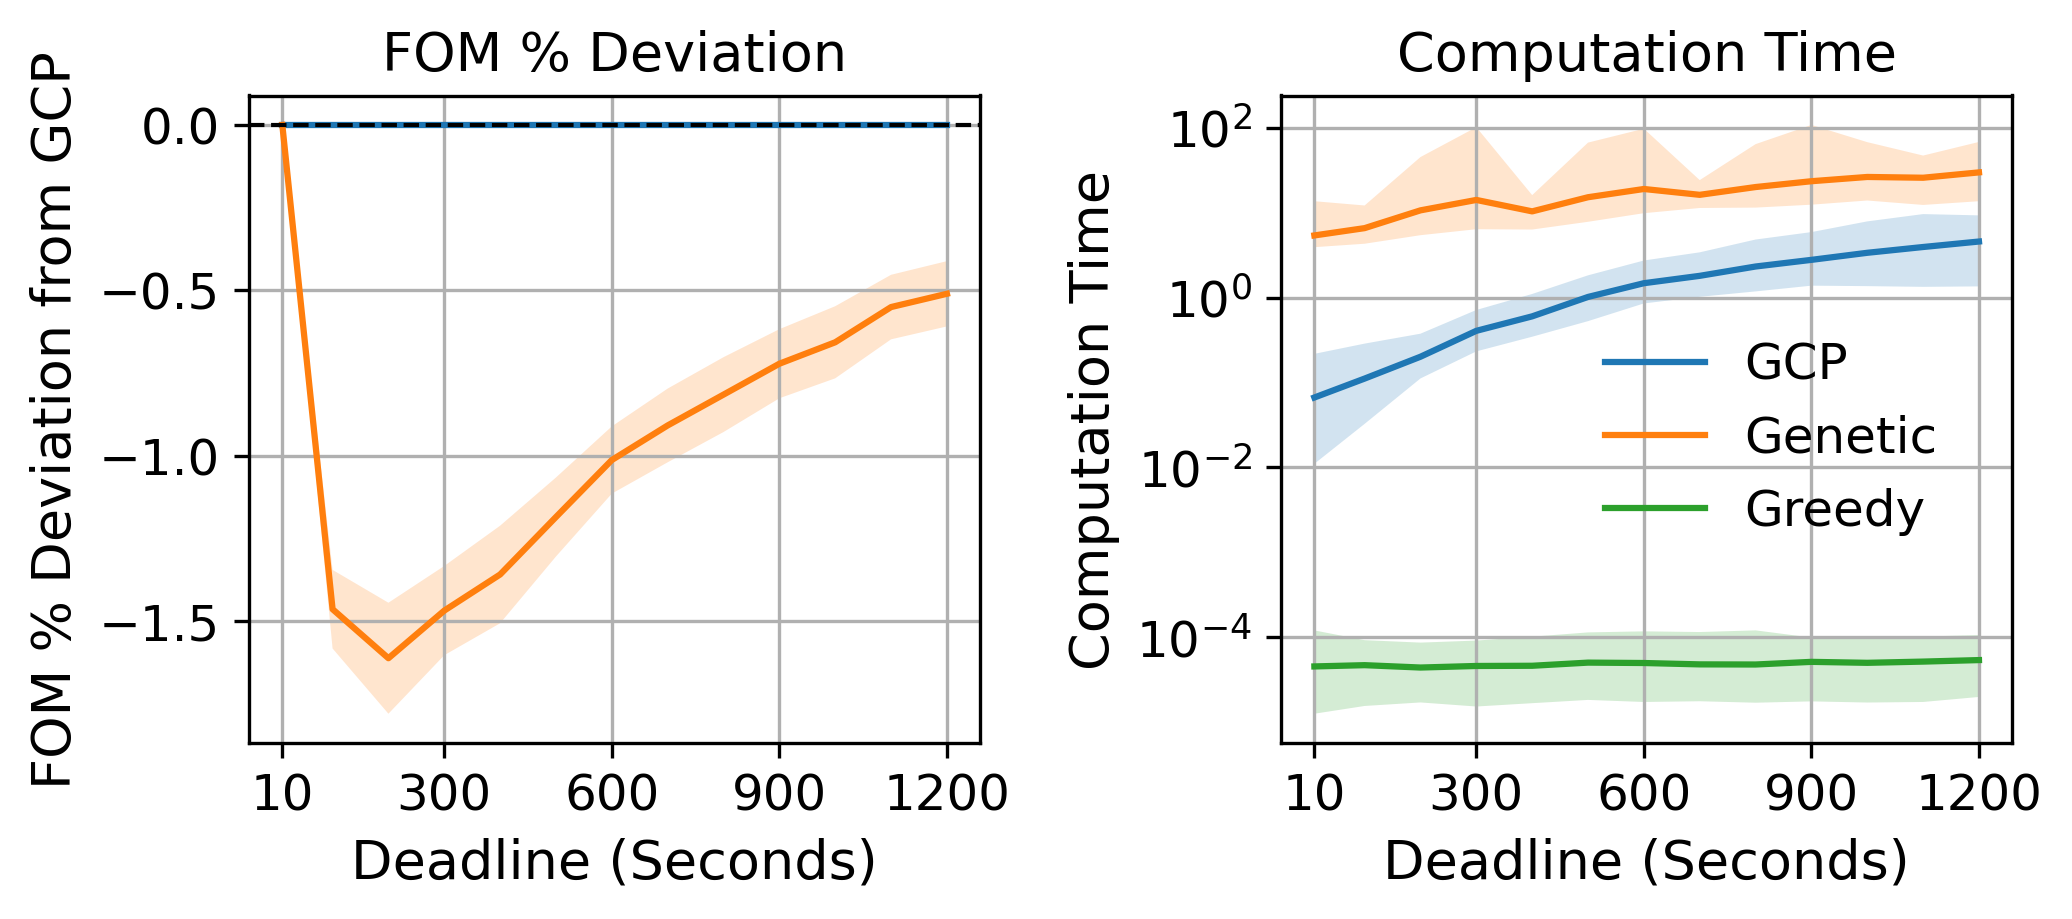

In [8]:
# Baseline for deviation (GCP)
baseline = (
    df_filtered[df_filtered['DisplayMethod'] == 'GCP']
    [['DatasetName', 'Budget', 'SumProb']]
    .rename(columns={'SumProb': 'BaselineFOM'})
)

# Rebuild df_dev for the current dataset (avoid stale state)
df_dev = df_filtered.merge(baseline, on=['DatasetName', 'Budget'], how='inner')
df_dev['FOMPctDeviation'] = 100.0 * (df_dev['SumProb'] - df_dev['BaselineFOM']) / df_dev['BaselineFOM']

agg_pct_dev = (
    df_dev.groupby(['DisplayMethod', 'Budget'])['FOMPctDeviation']
    .agg(['mean', sem]).reset_index()
)
agg_time = (
    df_filtered.groupby(['DisplayMethod', 'Budget'])['TimeSec']
    .agg(['mean', 'min', 'max']).reset_index()
)

x_ticks = sorted(df_filtered['Budget'].unique())
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(7.2, 3.5), dpi=300)

# Left: Computation Time
for m in agg_time['DisplayMethod'].unique():
    sub = agg_time[agg_time['DisplayMethod'] == m]
    ax1.plot(sub['Budget'], sub['mean'], label=m)
    ax1.fill_between(sub['Budget'], sub['min'], sub['max'], alpha=0.2)
ax1.set_xlabel("Deadline (Seconds)")
ax1.set_ylabel("Computation Time")
ax1.set_yscale("log")
ax1.set_xticks(x_ticks[::3])
ax1.set_title("Computation Time")
ax1.grid(True)

#Right: % Deviation
for m in agg_pct_dev['DisplayMethod'].unique():
    if m == "Greedy":
        continue
    sub = agg_pct_dev[agg_pct_dev['DisplayMethod'] == m]
    ax2.plot(sub['Budget'], sub['mean'], label=m)
    ax2.fill_between(sub['Budget'], sub['mean'] - sub['sem'], sub['mean'] + sub['sem'], alpha=0.2)
ax2.axhline(0, linestyle='--', color='black', linewidth=1)
ax2.set_xlabel("Deadline (Seconds)")
ax2.set_ylabel("FOM % Deviation from GCP")
ax2.set_xticks(x_ticks[::3])
ax2.set_title("FOM % Deviation")
ax2.grid(True)

# Shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.75, 0.35), ncol=1, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("figures/Fig8_Small_Instances_Single_Deadline.png", dpi=300)
plt.show()

## Section 3: Figure 9, Small Instances with MOET-Aware Budgeting

- Incorporates method-specific maximum-observed execution time into budget computation.

- Reduces each strategy’s deadline by its maximum-observed execution time to simulate execution overhead.

- Plots average FoM vs. deadline under these real-time constraints.



In [9]:
folder_path = f"{root_path}/instances_with_moet/result_with_moet"
df_all = read_and_aggregate(folder_path)
df_filtered = df_all[df_all['Method'].isin(selected_methods)].copy()
df_filtered["DisplayMethod"] = df_filtered["Method"].map(method_display_names)

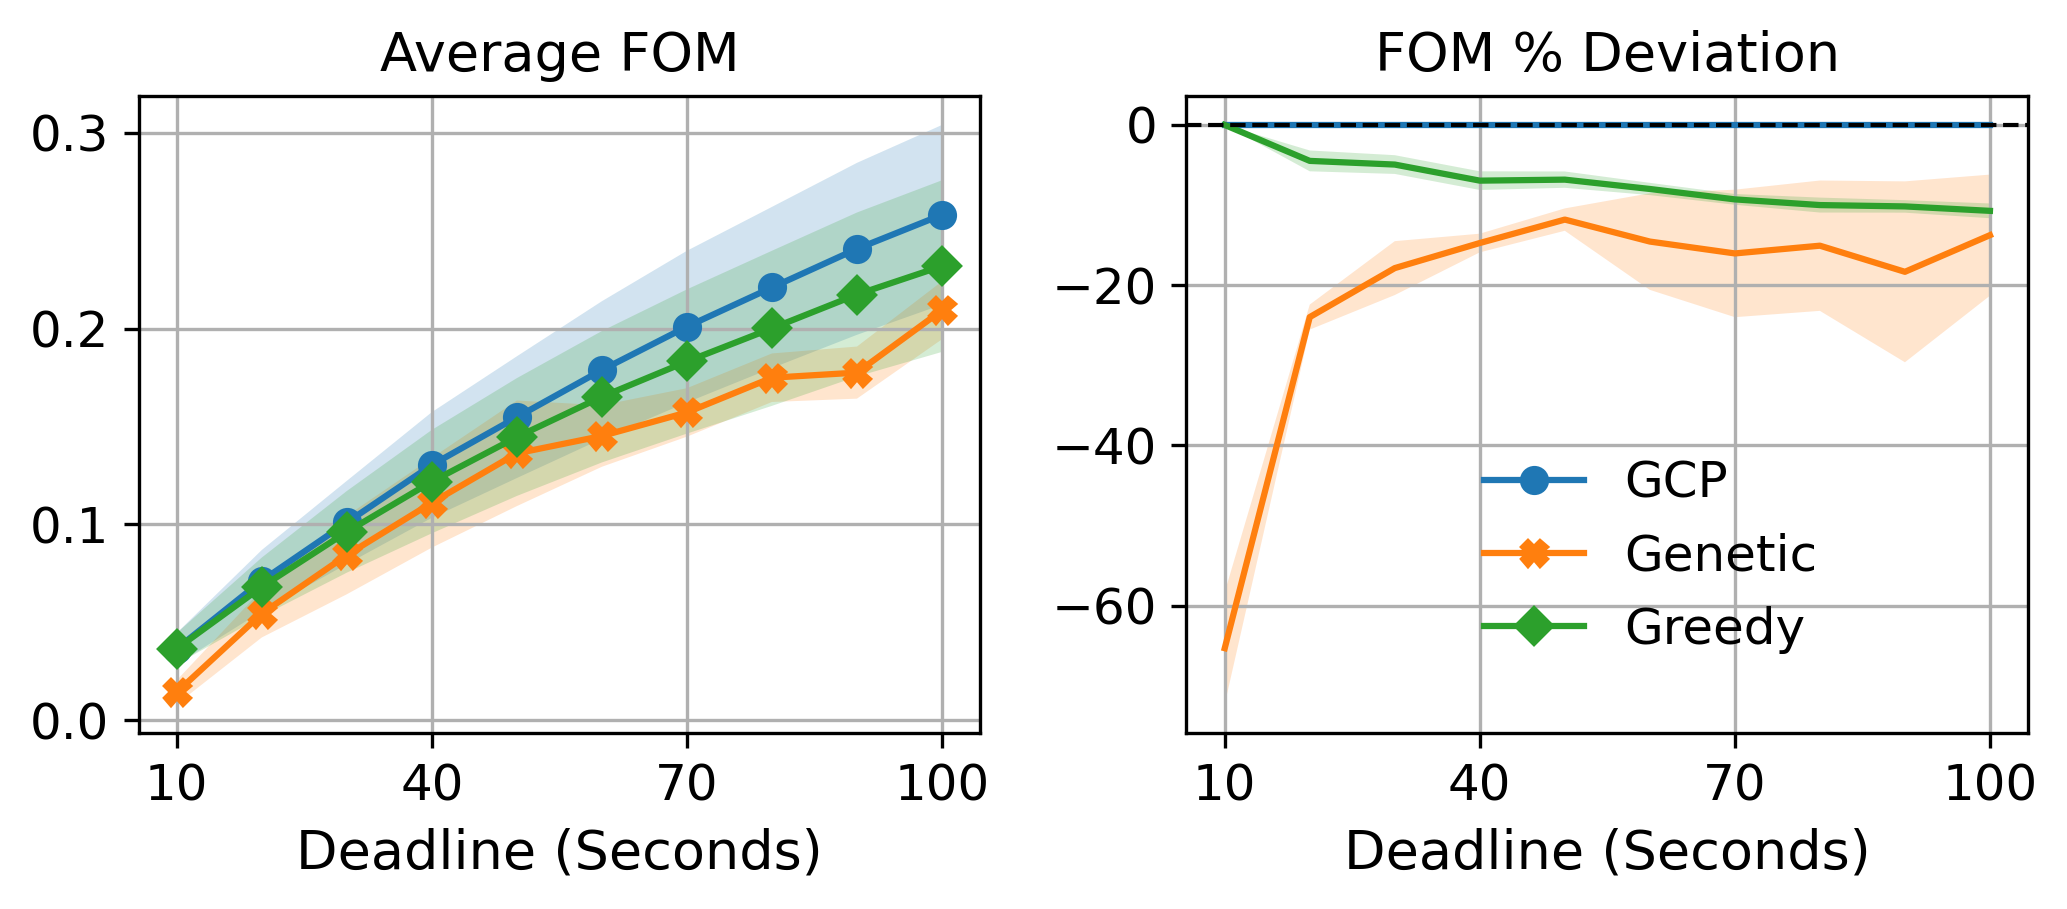

In [10]:
# Average FOM by method & deadline
agg_fom = (
    df_filtered
    .groupby(['DisplayMethod', 'Budget'])['SumProb']
    .agg(['mean', sem])
    .reset_index()
)

# %-deviation from GCP baseline 
df_dev = df_filtered.copy()

# Build the baseline: mean FOM of GCP
baseline = (
    df_filtered[df_filtered['DisplayMethod'] == 'GCP'][['DatasetName', 'Budget', 'SumProb']]
    .rename(columns={'SumProb': 'BaselineFOM'})
)
df_dev = df_dev.merge(baseline, on=['DatasetName', 'Budget'])
df_dev['FOMPctDeviation'] = 100.0 * (df_dev['SumProb'] - df_dev['BaselineFOM']) / df_dev['BaselineFOM']

agg_pct = (
    df_dev
    .groupby(['DisplayMethod', 'Budget'])['FOMPctDeviation']
    .agg(['mean', sem])
    .reset_index()
)

# 
budgets_sorted = sorted(df_filtered['Budget'].unique())
xticks_main    = budgets_sorted[::3]  

fig, (ax_left, ax_right) = plt.subplots(
    1, 2, figsize=(7.2, 3.5), dpi=300, sharex=False
)

# Left: Average FOM 
for method in agg_fom['DisplayMethod'].unique():
    sub = agg_fom[agg_fom['DisplayMethod'] == method]
    marker = method_markers.get(method, 'o') if 'method_markers' in globals() else 'o'
    ax_left.plot(
        sub['Budget'], sub['mean'],
        marker=marker, label=method
    )
    ax_left.fill_between(
        sub['Budget'],
        sub['mean'] - sub['sem'],
        sub['mean'] + sub['sem'],
        alpha=0.2
    )

ax_left.set_xlabel("Deadline (Seconds)")
ax_left.set_xticks(xticks_main)
ax_left.grid(True)
ax_left.set_title("Average FOM")

# Right: % Deviation 
for method in agg_pct['DisplayMethod'].unique():
    sub = agg_pct[agg_pct['DisplayMethod'] == method]
    ax_right.plot(
        sub['Budget'], sub['mean'], label=method
    )
    ax_right.fill_between(
        sub['Budget'],
        sub['mean'] - sub['sem'],
        sub['mean'] + sub['sem'],
        alpha=0.2
    )

ax_right.axhline(0, color='black', linestyle='--', linewidth=1)
ax_right.set_xlabel("Deadline (Seconds)")
ax_right.set_xticks(xticks_main)
ax_right.set_title("FOM % Deviation")
ax_right.grid(True)


# Shared Legend
handles, labels = ax_left.get_legend_handles_labels()
ax_right.legend(
    handles, labels,
    loc='upper left', 
    bbox_to_anchor=(0.3, 0.5),
    ncol=1,
    frameon=False
)


plt.tight_layout(rect=[0, 0.08, 1, 1])  
plt.savefig("figures/Fig9_WCET_FOM_and_Deviation.png", dpi=300, bbox_inches='tight')
plt.show()


## Section 4: Figure 10, Large Instances with Multiple Deadlines

- Evaluates strategies across multiple deadlines, where the search task is divided across segments.

- Each strategy (e.g., `SO1`–`SO5`) defines how deadlines are distributed among segments.


In [11]:

markers = {
    'SO1': 'o',
    'SO2': 's',
    'SO3': 'D',
    'SO4': '^',
    'SO5': 'v',
    'D6': 'X',
    'D7': 'P'
}

base_betas = [1.0, 1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0]
selected_indices = [1, 2, 5]
labels = ["SO1", "SO2", "SO3", "SO4", "SO5", "D6"]

# Compute segment ranges
ranges = [(0, selected_indices[0])]
for i in range(len(selected_indices) - 1):
    ranges.append((selected_indices[i] + 1, selected_indices[i + 1]))

# Select corresponding beta values
selected_beta = [base_betas[i] for i in selected_indices]


def plotMultiDeadlines(df, figurename):
    plt.figure(figsize=(3, 3), dpi=150)
    selected_deadlines = set()
    for idx, label in zip(selected_indices, labels):
        row = df.iloc[idx]
        fom = row["FOMs"]
        # Accumulate FoM over defined ranges
        segment_fom = [sum(fom[a:b+1]) for a, b in ranges]
        # Compute discounted cumulative FoM
        efom = []
        acc = 0.0
        for beta, f in zip(selected_beta, segment_fom):
            acc += beta * f
            efom.append(acc)

        # Plot only selected deadlines
        deadlines = row["Budgets"]
        selected_deadlines = [deadlines[i] for i in selected_indices]

        plt.plot(
            selected_deadlines,
            efom,
            label=label,
            marker=markers.get(label, 'o'),
            linewidth=1.5,
            markersize=6
        )

    plt.xlabel("Deadlines (Seconds)")
    plt.ylabel("Expected FoM")
    plt.xticks(selected_deadlines)
    plt.legend()
    plt.ylim(bottom=0.03)
    plt.tight_layout()
    plt.savefig(f"figures/{figurename}", dpi=300, bbox_inches='tight')
    plt.show()

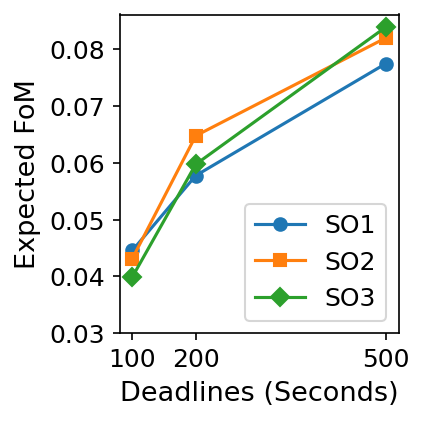

In [12]:
# Load data for map GW200322_091133
path = f"{root_path}/multi_deadlines"
fname = "GW200322_091133"
filepath = f"{path}/multi_filtered_{fname}_7dt_separate.csv"
df = pd.read_csv(filepath)
df["FOMs"] = df["FOMs"].apply(lambda x: list(map(float, str(x).split())))
df["Budgets"] = df["Budgets"].apply(lambda x: list(map(float, str(x).split())))
plotMultiDeadlines(df, "Fig10_Top_FOM_Progression_Diffuse.png")

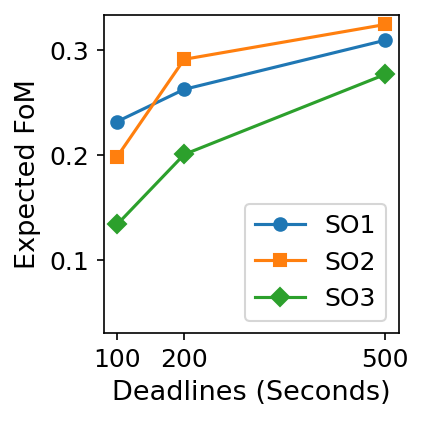

In [13]:
# Load data for map GW200216_220804
path = f"{root_path}/multi_deadlines"
fname = "GW200216_220804"
filepath = f"{path}/multi_filtered_{fname}_7dt.csv"
df = pd.read_csv(filepath)
df["FOMs"] = df["FOMs"].apply(lambda x: list(map(float, str(x).split())))
df["Budgets"] = df["Budgets"].apply(lambda x: list(map(float, str(x).split())))
plotMultiDeadlines(df, "Fig10_Bottom_FOM_Progression_Concentrated.png")